# IBM: Feature Engineering and Bias Detection

### Class Imbalance
If one or more classes in your data are underrepresented you could be introducing bias into your models. Working with imbalanced data may also lead your analysis to incorrect or misleading conclusions. Understanding this will help you keep class balance and bias in perspective as you proceed through the data analysis pipeline.
Dealing with problems of class imbalance often requires finesse, and this unit introduces several potential approaches. These methods employ different tactics to avoid being overwhelmed by the majority class. Typically being overwhelmed during the model’s training directly affects the model’s accuracy. Accuracy, that is the proportion of predictions that are correct, is an intuitive metric for classification, but can be misleading with imbalanced classes. For example, if one percent of a processor’s transactions in a training sample are fraudulent, then a model that always predicts “not fraudulent” will be 99% accurate but of no practical use.
#### WARNING: Accuracy is not an appropriate metric for imbalanced classes. Use F1 Score (harmonic mean) or another metric instead.
<b>The solution to misleading metrics</b> is to break the correct vs. incorrect dichotomy of binary classification into four pieces: true positives, true negatives, false positives, and false negatives. There are many ways to combine these values with an even larger number of naming conventions. <br> <img src='images/extension.png'> <br>
<b>The solution to imbalanced classes</b> is to <b>up-sample</b> or <b>down-sample</b> data, making the minority class more common through some type of repetition or making the majority class less common by throwing away some observations.

### Up-sampling & down-sampling
The most common approaches are sampling based, or more specifically, re-sampling based. Between up-sampling and down-sampling (also called over-sampling and under-sampling), down-sampling is a bit simpler conceptually. Fundamentally, if you have a minority class or classes that is noticeably underrepresented. In a random way you can drop some of those from the training data so that the proportions are more closely matched across classes. There are additional methods, one of which is inspired by K Nearest Neighbors (KNN) that can improve on pure random selection. <br>
A major caveat to down-sampling is that we are not using all of our data. Over-sampling techniques also come in several flavors, from random or naive versions to classes of algorithms like the Synthetic Minority Oversampling Technique (SMOTE) and the Adaptive Synthetic (ADASYN) sampling method. Synthetic Minority Over-sampling Technique for Nominal and Continuous (SMOTENC) is an extension of the original SMOTE method designed to handle a mixture of categorical and continuous features. SMOTE has a number of other variants including ones that make use of Support Vector Machines and K-means clustering to improve on the synthetic samples.



In [26]:
# import essentials
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import load_boston

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import median_absolute_error, r2_score

import plotly.express as px  # interactive data visualization

sns.set()
%matplotlib inline

In [27]:
# quick example of StandardScaler()

In [28]:
# quick example of Pipelines

boston = load_boston()                                                                                   ## load the boston dataset
X, y = boston['data'], boston['target']
features = boston['feature_names']

## split the data to a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## create a pipeline
pipe = make_pipeline((StandardScaler()),
                     (SelectKBest(k=10)),
                     (RandomForestRegressor(n_estimators=20)))

## train on the training data
pipe.fit(X_train, y_train)

## evaluate the model with the test data
y_pred = pipe.predict(X_test)
print(r'R^2=%.2f, MAE=%.2f'%(r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred))) 

R^2=0.76, MAE=1.35


## Case-study
- <i>Model Sensitivity to Class Imbalance</i>: some models are more or less sensitive to class imbalance
- <i>Sampling Techniques</i>: up-sampling and down-sampling
- <i>Imbalanced-learn</i>: introduce the package and use SMOTE as an example

In [38]:
imbalanced = pd.read_csv('datasets/aavail-target.csv')
print(imbalanced.head(3))
imbalanced.info()

   customer_id  is_subscriber        country  age  customer_name  \
0            1              1  united_states   21     Kasen Todd   
1            2              0      singapore   30   Ensley Garza   
2            3              0  united_states   21  Lillian Carey   

    subscriber_type  num_streams  
0    aavail_premium           23  
1  aavail_unlimited           12  
2    aavail_premium           22  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customer_id      1000 non-null   int64 
 1   is_subscriber    1000 non-null   int64 
 2   country          1000 non-null   object
 3   age              1000 non-null   int64 
 4   customer_name    1000 non-null   object
 5   subscriber_type  1000 non-null   object
 6   num_streams      1000 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 54.8+ KB


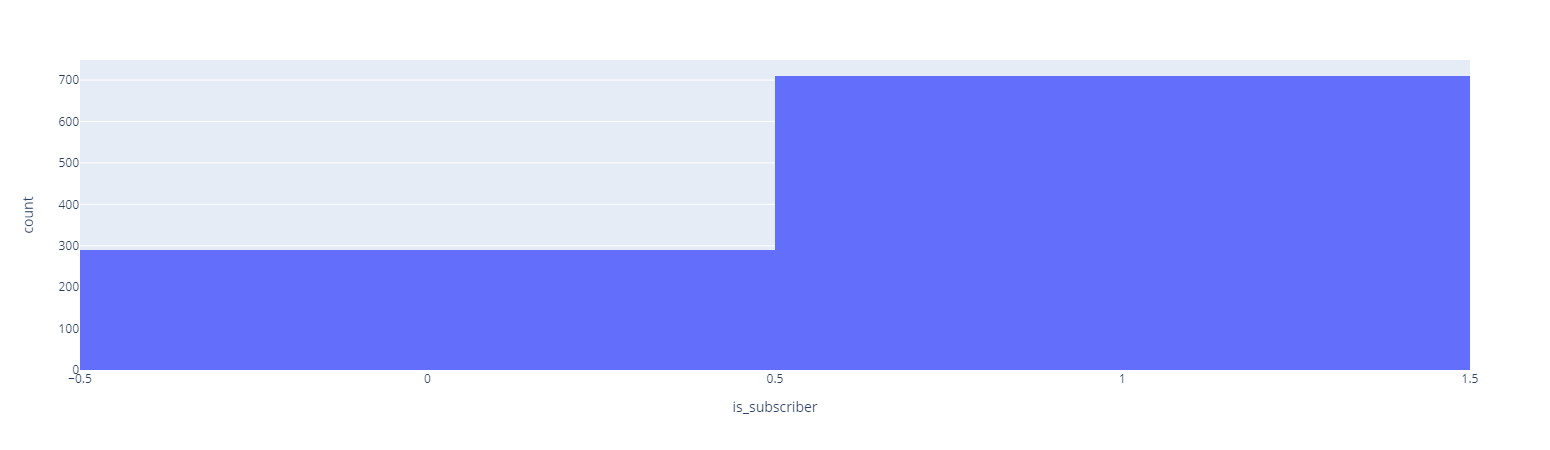

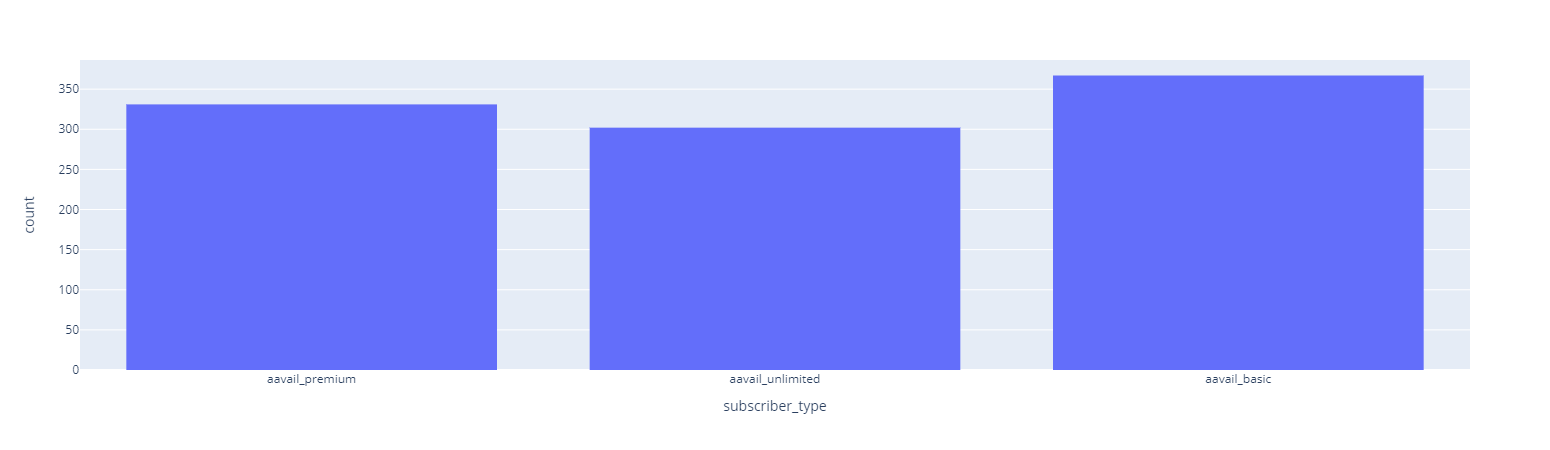

In [35]:
fig = px.histogram(imbalanced, x='is_subscriber')
fig.show()

fig = px.histogram(imbalanced, x='subscriber_type')
fig.show()

In [36]:
imbalanced[imbalanced.is_subscriber == 0]['subscriber_type']

1      aavail_unlimited
2        aavail_premium
6          aavail_basic
8        aavail_premium
9          aavail_basic
             ...       
974        aavail_basic
977      aavail_premium
979      aavail_premium
991      aavail_premium
995    aavail_unlimited
Name: subscriber_type, Length: 289, dtype: object

In [39]:

# pull out the target and remove unnecessary columns
_y = imbalanced.pop('is_subscriber')
y = np.zeros(_y.size)
y[_y == 0] = 1
imbalanced.drop(columns=['customer_id', 'customer_name'], inplace=True)

# split the data
X_train, X_test, y_train, y_test = train_test_split(imbalanced, y, test_size=.2, stratify=y)

In [43]:
print('Train Set:\n', pd.DataFrame(y_train, columns=['vals']).value_counts())
print('\n')
print('Test Set:\n', pd.DataFrame(y_test, columns=['vals']).value_counts())

Train Set:
 vals
0.0     569
1.0     231
dtype: int64


Test Set:
 vals
0.0     142
1.0      58
dtype: int64


In [46]:
from collections import Counter
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_test).items()))



[(0.0, 569), (1.0, 231)]
[(0.0, 142), (1.0, 58)]


In [48]:
# transformation pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline 

from sklearn.linear_model import LogisticRegression

numeric_features = ['age', 'num_streams']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['country', 'subscriber_type']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# model pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs'))
])


In [50]:
from sklearn.metrics import classification_report 

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['subscriber', 'churn']))

              precision    recall  f1-score   support

  subscriber       0.83      0.87      0.85       142
       churn       0.63      0.57      0.60        58

    accuracy                           0.78       200
   macro avg       0.73      0.72      0.72       200
weighted avg       0.77      0.78      0.78       200



## Imbalanced Learn
- Simple interface & integrations with sklearn
- Neural Networks: imblearn.keras & imblearn.tensorflow
- SMOTE & related variants
- Works naturally with pipelines

In [54]:
# !pip install -U imbalanced-learn

In [60]:
# example with toy dataset
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

# instantiate data
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                          n_redundant=0, n_repeated=0, n_classes=3,
                          n_clusters_per_class=1, weights=[.01, .05, .94],
                          class_sep=.8, random_state=0)
print('Original Target')
print(sorted(Counter(y).items()))
print(f'X shape: {X.shape}\ny shape: {y.shape}')

Original Target
[(0, 64), (1, 262), (2, 4674)]
X shape: (5000, 2)
y shape: (5000,)


In [61]:
X_resampled, y_resampled = RandomOverSampler(random_state=0).fit_resample(X, y)
print('Resampled Target')
print(sorted(Counter(y_resampled).items()))
print(f'Resampled X shape: {X_resampled.shape}\nResampled y shape: {y_resampled.shape}')

Resampled Target
[(0, 4674), (1, 4674), (2, 4674)]
Resampled X shape: (14022, 2)
Resampled y shape: (14022,)


## Class Imbalance Complete Pipeline

In [62]:
import imblearn.pipeline as pl
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [64]:
# ORIGINAL PIPELINE
clf1 = pl.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs'))
])

clf2 = pl.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', RandomOverSampler(random_state=42)),
    ('classifier', LogisticRegression(solver='lbfgs'))
])

clf3 = pl.Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(solver='lbfgs'))
])

for clf in [clf1, clf2, clf3]:
    clf.fit(X_train, y_train)

In [65]:
for name, clf in [('no sampling', clf1), ('random oversampling', clf2), ('SMOTE', clf3)]:
    y_pred = clf.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred, target_names=['subscriber', 'churn']))

no sampling
              precision    recall  f1-score   support

  subscriber       0.83      0.87      0.85       142
       churn       0.63      0.57      0.60        58

    accuracy                           0.78       200
   macro avg       0.73      0.72      0.72       200
weighted avg       0.77      0.78      0.78       200

random oversampling
              precision    recall  f1-score   support

  subscriber       0.83      0.82      0.83       142
       churn       0.57      0.60      0.59        58

    accuracy                           0.76       200
   macro avg       0.70      0.71      0.71       200
weighted avg       0.76      0.76      0.76       200

SMOTE
              precision    recall  f1-score   support

  subscriber       0.83      0.82      0.83       142
       churn       0.57      0.60      0.59        58

    accuracy                           0.76       200
   macro avg       0.70      0.71      0.71       200
weighted avg       0.76      0.76   

## Models that Naturally Handle Imbalance

Some models are more sensitive to imbalanced classes than others. Neural networks for example are very sensitive to imbalanced classes. Support Vector Machines on the other hand and to some extent tree based methods are more resilient. If available, the class_weight argument should be used when working with imbalanced classes.
For example,
<code>
    clf = SVC(kernel='linear', class_weight='balanced', probability=True)
</code>

*<i><a href='https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html'>sklearn example using SVM & unbalanced data</a></i>